In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [5]:
def run(corruption_rates=[0., 0.], confidence_rates=[1., 1.]):
    '''rate: corruption rate. if 1, every label can be corrupted.'''
    # Data design
    X = np.random.randint(0, 3, (32*1100, 10), np.int32) # inputs
    Y = np.equal(np.concatenate((np.ones_like(X[:, :1]), np.sign(X[:, :-1])), 1), 0).astype(np.int32) # labels
    
    # Split them into training and validation data.
    X_train, X_test = np.split(X, [32*1000], axis=0)
    Y_train, Y_test = np.split(Y, [32*1000], axis=0)
    
    # Intentional Corruption
    chances = np.random.uniform(size=(32*1000, 10))
    condlist = [np.logical_and(Y_train==0, chances>=corruption_rates[0]), 
                np.logical_and(Y_train==0, chances<corruption_rates[0]),
                np.logical_and(Y_train==1, chances>=corruption_rates[1]),
                np.logical_and(Y_train==1, chances<corruption_rates[1])]
    choicelist = [0, 1, 1, 0]
    Z_train = np.select(condlist, choicelist)
    
    # Graph
    tf.reset_default_graph()
    
    # Mini batches
    x = tf.placeholder(tf.int32, (32, 10), name="x")
    y = tf.placeholder(tf.int32, (32, 10), name="true_label")
    z = tf.placeholder(tf.int32, (32, 10), name="corrupted_label")

    inputs = tf.one_hot(x, 3)
    
    # Label smoothing
    if confidence_rates is not None:
        cr0, cr1 = confidence_rates
    else:
        cr0 = tf.get_variable(name="cr0",
                            shape=(),
                            initializer=tf.constant_initializer(.9),
                            dtype=tf.float32)                                                   
        cr1 = tf.get_variable(name="cr1",
                            shape=(),
                            initializer=tf.constant_initializer(.9),
                            dtype=tf.float32)
    table = tf.convert_to_tensor(
                [[cr0, 1.-cr0], 
                 [1.-cr1, cr1]])

    labels = tf.nn.embedding_lookup(table, z)

    # network
    cell = tf.nn.rnn_cell.GRUCell(100)
    outputs, _  = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    logits = tf.layers.dense(outputs, 2)
    preds = tf.argmax(logits, -1, output_type=tf.int32)

    # metric
    hits = tf.reduce_sum(tf.to_float(tf.equal(preds, y))) # <- metric should be computed from true labels.
    acc = hits / tf.to_float(tf.size(x))

    # Loss and training
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(loss)

    global_step = tf.Variable(0, name='global_step', trainable=False)
    optimizer = tf.train.AdamOptimizer(0.001)
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    # Session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        global_steps, losses, train_accs, val_accs, cr0s, cr1s = [], [], [], [], [], []
        stop_msg = False
        for i in range(0, 32*1000, 32):
            _x = X_train[i:i+32]
            _y = Y_train[i:i+32]
            _z = Z_train[i:i+32]
        
            _, gs, _loss, _acc = sess.run(
                [train_op, global_step, loss, acc], 
                                          {x: _x, y: _y, z:_z})
        
            losses.append(_loss)
            train_accs.append(_acc)
            
            if gs % 10 == 0:
                total_hits = 0
                for j in range(0, 32*100, 32):
                    x_ = X_test[j:j+32]
                    y_ = Y_test[j:j+32] 
                    total_hits += sess.run(hits, {x: x_, y: y_, z:_z})
                global_steps.append(gs)
                val_acc = total_hits / float(X_test.size)
                val_accs.append(val_acc)
                if not stop_msg and val_acc==1.: 
                    print("Ater global steps {}, the validation accuracy reached 1.".format(gs))
                    stop_msg=True
        # Plot
        plt.plot(losses, label="loss")
        plt.plot(train_accs, label="train_accuracy")
        plt.plot(global_steps, val_accs, label="validation accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.grid()
        plt.show()
        
        

Ater global steps 100, the validation accuracy reached 1.


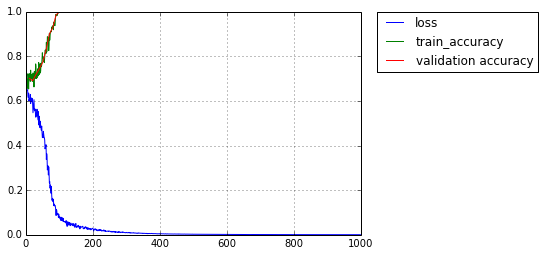

In [6]:
run()

Ater global steps 100, the validation accuracy reached 1.


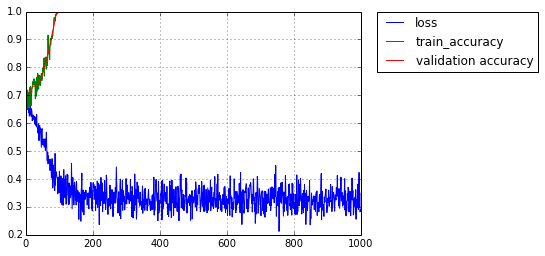

In [7]:
run(corruption_rates=[.1, .1])

Ater global steps 180, the validation accuracy reached 1.


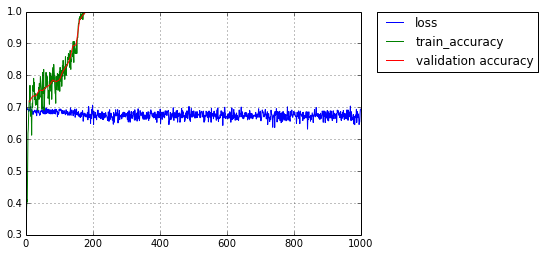

In [8]:
run(corruption_rates=[.4, .4])

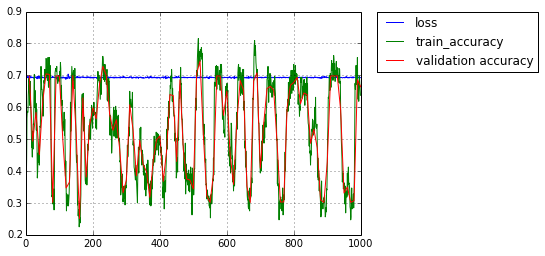

In [9]:
run(corruption_rates=[.5, .5])

Ater global steps 260, the validation accuracy reached 1.


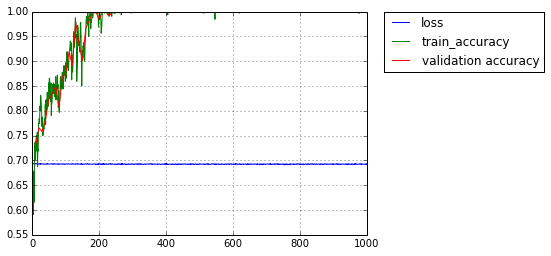

In [10]:
run(corruption_rates=[.4, .4], confidence_rates=[.6, .6])

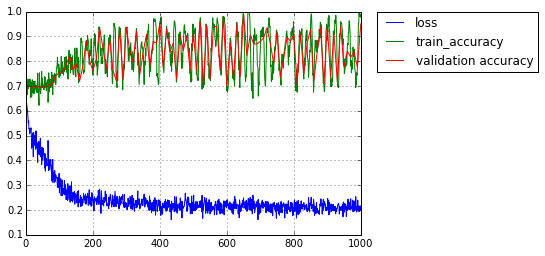

In [11]:
run(corruption_rates=[.0, 0.5])

Ater global steps 200, the validation accuracy reached 1.


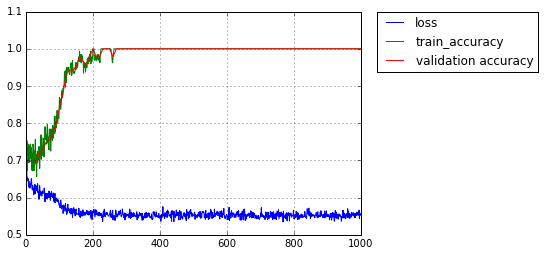

In [12]:
run(corruption_rates=[0., 0.5], confidence_rates=[0.8, 1.])